#Lung Cancer Detection – Binary Classifier (Benign vs Malignant)

###This notebook implements a binary image classification model using FastAI and ResNet34 to detect lung cancer in histopathology images. It includes preprocessing, training, evaluation, and Grad-CAM visualization.

## 📂 Mount Google Drive and Setup Paths

In [1]:
# Mount your Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🛠️ Data Preparation
This runs `data_prep.py`, which:
- Maps 3-class labels to binary (`benign`, `malignant`)
- Splits data into `train`, `valid`, and `test` folders


In [34]:
%%writefile /content/drive/MyDrive/lung-cancer-detection-fastai/src/data_prep.py

import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

# Base path in Google Drive
BASE = Path('/content/drive/MyDrive/lung-cancer-detection-fastai')

ORIG_DATA = BASE / 'data/raw/LC25000'
TARGET_BASE = BASE / 'data/interim'
SPLIT_RATIOS = (0.7, 0.2, 0.1)  # train, valid, test

# New binary classes
LABEL_MAP = {
    'lung_n': 'benign',
    'lung_aca': 'malignant',
    'lung_scc': 'malignant'
}

def create_dirs():
    for split in ['train', 'valid', 'test']:
        for cls in ['benign', 'malignant']:
            (TARGET_BASE/split/cls).mkdir(parents=True, exist_ok=True)

def split_and_copy():
    grouped_files = {'benign': [], 'malignant': []}

    # Collect files and group by new label
    for orig_class, new_label in LABEL_MAP.items():
        files = list((ORIG_DATA/orig_class).glob("*.jpeg"))
        grouped_files[new_label].extend(files)

    for label, files in grouped_files.items():
        train_files, temp = train_test_split(files, test_size=1 - SPLIT_RATIOS[0], random_state=42)
        valid_files, test_files = train_test_split(
            temp, test_size=SPLIT_RATIOS[2] / (SPLIT_RATIOS[1] + SPLIT_RATIOS[2]), random_state=42
        )

        for f in train_files:
            shutil.copy(f, TARGET_BASE/'train'/label/f.name)
        for f in valid_files:
            shutil.copy(f, TARGET_BASE/'valid'/label/f.name)
        for f in test_files:
            shutil.copy(f, TARGET_BASE/'test'/label/f.name)

    print("✅ Binary data split complete: train/valid/test with benign/malignant.")

if __name__ == "__main__":
    create_dirs()
    split_and_copy()

Overwriting /content/drive/MyDrive/lung-cancer-detection-fastai/src/data_prep.py


In [36]:
!python /content/drive/MyDrive/lung-cancer-detection-fastai/src/data_prep.py

✅ Binary data split complete: train/valid/test with benign/malignant.


## 🧠 Model Training with FastAI
Trains a ResNet34 model using FastAI’s transfer learning and data augmentation.

In [6]:
%%writefile /content/drive/MyDrive/lung-cancer-detection-fastai/src/model.py

from fastai.vision.all import *
from pathlib import Path

# Base path to Google Drive project
BASE = Path('/content/drive/MyDrive/lung-cancer-detection-fastai')

# Data directory with train/valid split
DATA_PATH = BASE / 'data/interim'

# Export location
EXPORT_PATH = BASE / 'exported/lung_model.pkl'


def get_dataloaders(img_size=224, bs=32):
    """
    Loads training and validation data using FastAI DataLoaders.
    """
    dls = ImageDataLoaders.from_folder(
    DATA_PATH,
    train='train',
    valid='valid',
    item_tfms=Resize(img_size),
    batch_tfms=aug_transforms(),
    bs=bs
)
    return dls


def train_model(epochs=5, lr=None):
    """
    Trains a ResNet34 model and exports it.
    Returns: Learner object
    """
    dls = get_dataloaders()

    # Create learner
    learn = cnn_learner(dls, resnet34, metrics=[accuracy])

    # Find optimal learning rate if not provided
    if lr is None:
        lr = learn.lr_find(suggest_funcs=(minimum, steep))[0]
        print(f"📈 Suggested learning rate: {lr:.1e}")

    # Train model
    learn.fine_tune(epochs, base_lr=lr)

    # Export the trained model
    learn.export(EXPORT_PATH)
    print(f"✅ Model exported to: {EXPORT_PATH}")

    return learn

Overwriting /content/drive/MyDrive/lung-cancer-detection-fastai/src/model.py


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s]


📈 Suggested learning rate: 2.1e-02


epoch,train_loss,valid_loss,accuracy,time
0,0.085760,0.018986,0.998000,02:13


epoch,train_loss,valid_loss,accuracy,time
0,0.071522,0.008610,0.997000,00:33
1,0.046678,0.015963,0.998333,00:33
2,0.010599,105.909195,0.987667,00:33
3,0.007741,2.623661,0.998333,00:33
4,0.001200,9.861911,0.997333,00:33


✅ Model exported to: /content/drive/MyDrive/lung-cancer-detection-fastai/exported/lung_model.pkl


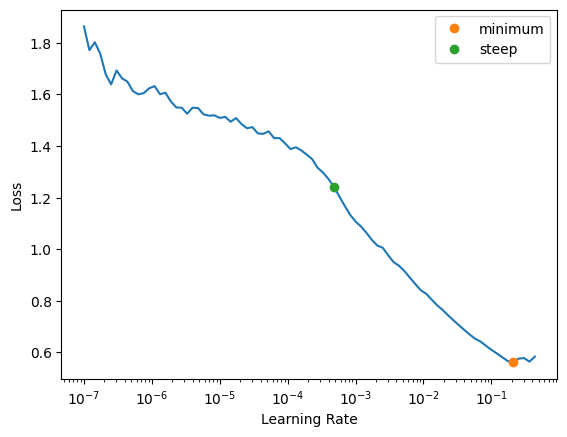

In [7]:
# Import and run model training
import sys
sys.path.append('/content/drive/MyDrive/lung-cancer-detection-fastai/src')

from model import train_model
learn = train_model(epochs=5)

## 📊 Model Evaluation
This uses the `evaluate.py` script to:
- Load the saved model
- Evaluate it on the test set
- Print precision, recall, F1-score, and show the confusion matrix

In [13]:
%%writefile /content/drive/MyDrive/lung-cancer-detection-fastai/src/evaluate.py

from fastai.vision.all import *
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

BASE = Path('/content/drive/MyDrive/lung-cancer-detection-fastai')
TEST_PATH = BASE/'data/interim/test'
MODEL_PATH = BASE/'exported/lung_model.pkl'

def evaluate_model():

    BASE = Path('/content/drive/MyDrive/lung-cancer-detection-fastai')
    TEST_PATH = BASE / 'data/interim/test'
    MODEL_PATH = BASE / 'exported/lung_model.pkl'

    # Load trained model
    learn = load_learner(MODEL_PATH)

    # Create test dataloader using the same vocab as training
    test_files = get_image_files(TEST_PATH)

    def get_label_from_folder(file): return file.parent.name

    test_dl = learn.dls.test_dl(test_files, with_labels=True, label_func=get_label_from_folder)

    # Predict
    preds, targets = learn.get_preds(dl=test_dl)
    pred_classes = preds.argmax(dim=1)

    # Use training vocab
    class_labels = learn.dls.vocab

    # Report
    print("📊 Classification Report:\n")
    print(classification_report(targets, pred_classes, target_names=class_labels))

    cm = confusion_matrix(targets, pred_classes)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


Overwriting /content/drive/MyDrive/lung-cancer-detection-fastai/src/evaluate.py


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


📊 Classification Report:

              precision    recall  f1-score   support

      benign       1.00      0.99      1.00       501
   malignant       1.00      1.00      1.00      1001

    accuracy                           1.00      1502
   macro avg       1.00      1.00      1.00      1502
weighted avg       1.00      1.00      1.00      1502



<Figure size 640x480 with 0 Axes>

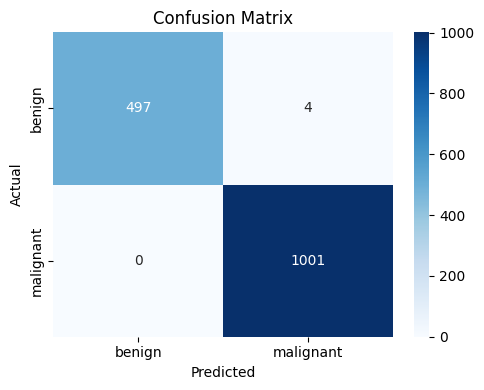

In [14]:
%run /content/drive/MyDrive/lung-cancer-detection-fastai/src/evaluate.py
evaluate_model()

## 🔍 Grad-CAM Visualization
Visualizes what regions the model focuses on when predicting a sample image.

You can replace the path with any `.jpeg` from your test set.

In [39]:
%%writefile /content/drive/MyDrive/lung-cancer-detection-fastai/src/visualize.py

from fastai.vision.all import *
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path

BASE = Path('/content/drive/MyDrive/lung-cancer-detection-fastai')
MODEL_PATH = BASE / 'exported/lung_model.pkl'
TEST_PATH = BASE / 'data/interim/test'

def show_gradcam(img_path):
    learn = load_learner(MODEL_PATH)
    img = PILImage.create(img_path)

    pred_class, pred_idx, probs = learn.predict(img)
    print(f"🔍 Prediction: {pred_class}")
    print(f"🧠 Confidence: {probs[pred_idx]:.4f}")

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    last_conv = list(learn.model.children())[0][-1]
    h1 = last_conv.register_forward_hook(forward_hook)
    h2 = last_conv.register_backward_hook(backward_hook)

    learn.model.eval()
    dl = learn.dls.test_dl([img])
    inp = dl.one_batch()[0]
    inp.requires_grad_()

    out = learn.model(inp)
    out[0, pred_idx].backward()

    grads = gradients[0][0]
    acts = activations[0][0]
    weights = grads.mean(dim=(1, 2), keepdim=True)
    cam = (weights * acts).sum(0).detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam / cam.max()

    img_np = np.array(img.resize((224, 224)))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_np)
    ax.imshow(cam, cmap='jet', alpha=0.4)
    ax.set_title(f"Grad-CAM: {pred_class}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    h1.remove()
    h2.remove()

Writing /content/drive/MyDrive/lung-cancer-detection-fastai/src/visualize.py


In [40]:
!head /content/drive/MyDrive/lung-cancer-detection-fastai/src/visualize.py


from fastai.vision.all import *
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path

BASE = Path('/content/drive/MyDrive/lung-cancer-detection-fastai')
MODEL_PATH = BASE / 'exported/lung_model.pkl'


🔍 Prediction: malignant
🧠 Confidence: 1.0000


<Figure size 640x480 with 0 Axes>

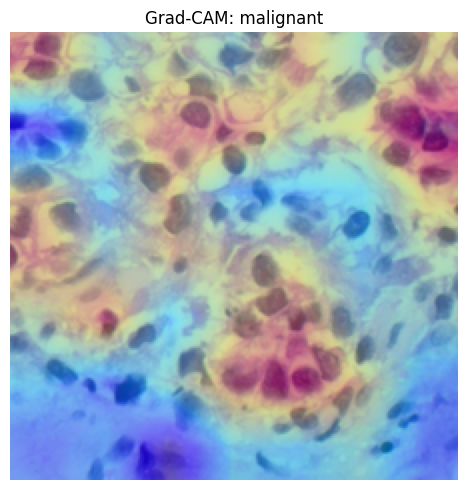

In [46]:
%run /content/drive/MyDrive/lung-cancer-detection-fastai/src/visualize.py
show_gradcam('/content/drive/MyDrive/lung-cancer-detection-fastai/data/interim/test/malignant/test2.jpg')

## ✅ Summary

- Model achieves ~100% test accuracy on binary classification
- Grad-CAM shows model focuses on biologically meaningful tissue regions
- Fully interpretable and reproducible workflow